In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from glob import glob

cmap_tab = plt.get_cmap('tab10')
cmap_seq = plt.get_cmap('viridis')
cmap_blue = plt.get_cmap('Blues')

In [2]:
def eqm_binding(conc, K_D, high):
    return high*conc/(conc + K_D)

def eqm_binding_complex(conc_protein,conc_peptide,low,high,K_D):
    KDsum = conc_protein + conc_peptide + K_D
    f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)
    return low + f_bound*(high-low)

/var/folders/1r/_dnhk2ss6m3fr8s3lgl4kcmw0000gn/T/ipykernel_46135/1206017829.py:6: RuntimeWarning: invalid value encountered in sqrt
  f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)


0 [2.37246420e+02 4.13535716e+02 3.80506552e-01]


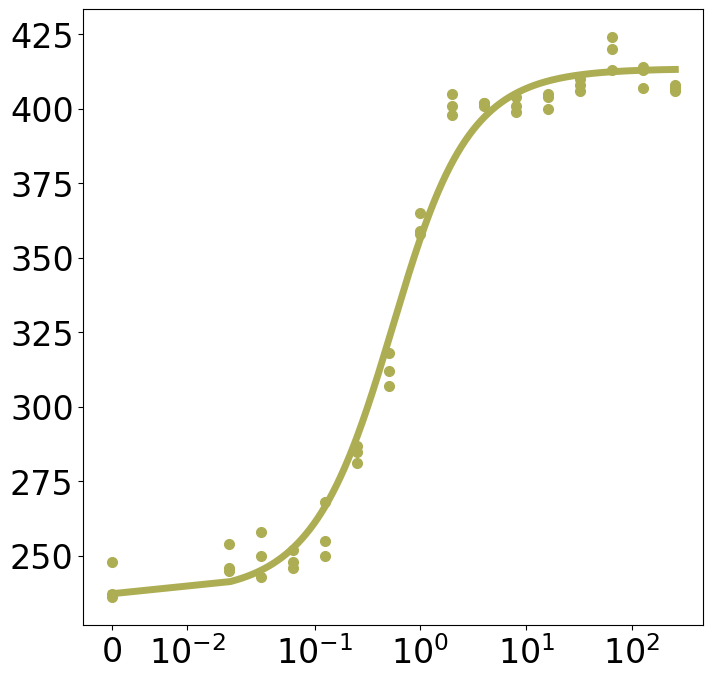

In [9]:
plt.figure(figsize=[8,8])

concs = [256/(2**i) for i in range(15)] + [0]

files = ['20250722_Laura_FP/CSM8_FPv2.csv','20250722_Laura_FP/CSM8-L11_FPv2.csv']
colors = ['#ADAE54','#48327F']
names = ['CSM8','CSM8-L11']
for i in range(1):

    data = pd.read_csv(files[i],index_col=0)
    data = np.concatenate([data.loc['A':'C',:].values,data.loc['D':'F',:'4'].values],axis=1).T
    
    params,_ = curve_fit(lambda x,a,b,c: eqm_binding_complex(x,0.3,a,b,c),
                         np.tile(concs,[3,1]).T.flatten(),data.flatten(),p0=[80,250,concs[8]])
    
    x_fit = np.concatenate([[0],
                        np.logspace(np.log10(0.5*concs[-2]),np.log10(concs[0]),1000)],axis=0)
    y_fit = eqm_binding_complex(x_fit,0.3,*params)
    plt.plot(x_fit,y_fit,'-',linewidth=5,color=colors[i],label=names[i])
    plt.plot(concs,data,'o',markersize=7,color=colors[i])

    print(i,params)

plt.xscale('symlog',linthresh=concs[-2])
# plt.legend(loc=[0.025,0.8],fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(f'FITC-gp33_binding.png',dpi=300,bbox_inches='tight')

In [22]:
data.shape

(16, 3)

gp33 [1.40510774e+01 2.87028733e+08] [8.36374962e-01 5.14514829e+06]
PF [7.56247125e+01 2.78981663e+08] [4.27139838e+00 7.30916246e+06]
Y4F [6.09381348e+02 6.88796542e+08] [6.36505909e+01 6.37332813e+07]


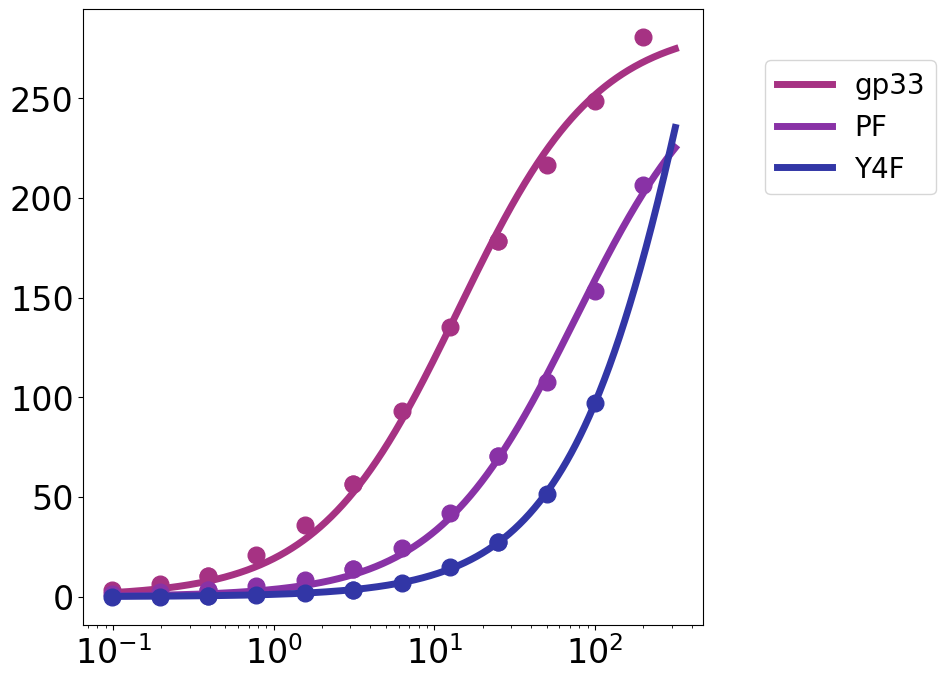

In [33]:
plt.figure(figsize=[8,8])
x_scale = 1e6

colors = ['#A63283','#8932A6','#3236A6']
for i,pep in enumerate(['gp33', 'PF', 'Y4F']):

    data_eq = pd.read_csv(glob(f'SPR raw data on smartMHC/202210 SPR wwDb/* wwDb {pep}.txt')[0],sep='\t')
    data_eq = data_eq[~np.isnan(data_eq['X'])]
    
    params,cov = curve_fit(eqm_binding,data_eq["X"],data_eq["Y"],p0=[3e-5,300],bounds=[0,np.inf])
    
    x_fit = np.logspace(-7,-3.5,1000)
    y_fit = eqm_binding(x_fit,*params)
    
    print(pep, params*1e6, np.sqrt(cov)[[0,1],[0,1]]*1e6)
    
    plt.semilogx(data_eq['X']*x_scale,data_eq['Y'],'o',color=colors[i],markersize=12)
    plt.semilogx(x_fit*x_scale,y_fit,'-',color=colors[i],linewidth=5,label=pep)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc=[1.1,0.7],fontsize=20)
plt.savefig(f'gp33_variant_TCR_binding_eqm.png',dpi=300,bbox_inches='tight')